# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

In [98]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

def get_data_loaders_cifar10(batch_size=100):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, 10
print("sanity check")

train,test,num_classes=get_data_loaders_cifar10()

sanity check
Files already downloaded and verified
Files already downloaded and verified


In [99]:
    pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-siy8vtwy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-siy8vtwy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [100]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

# loading the model
model, preprocess = clip.load("ViT-B/32", device=device)


# CIFAR-10 class labels
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create text embeddings for each class label
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10_classes]).to(device)

with torch.no_grad():
    z_txt = model.encode_text(text_inputs).to(device)

print("Text embedding shape:", z_txt.shape)  # Check the shape of the embeddings


def zero_shot(image_embed,text_embed):
  # Compute cosine similarity between image and text embeddings
    image_embed1=image_embed
    text_embed1=text_embed
    image_embed1 /= image_embed1.norm(dim=-1, keepdim=True)
    text_embed1 /= text_embed1.norm(dim=-1, keepdim=True)

    similarities = (image_embed1 @ text_embed1.T).squeeze(0)  # Cosine similarity
    pred = similarities.argmax(dim=1)  # Get index of the most similar class

    return pred

def accuracy_zero_shot(predicted_class):
  # find accuracy
    correct=0
    total=0
    for i in range(len(predicted_class)):
      if cifar10_classes[predicted_class[i].item()]==cifar10_classes[label[i].item()]:
        correct+=1
      total+=1
    acc=correct/total

    return acc


# Get a batch of data (image and label)
for batch in train:
    image, label = batch  # batch contains images and labels
    image = image.to(device)
    # image_preprocessed = preprocess(image[0]).unsqueeze(0).to(device)  # Preprocess the image and add batch dimension

    # Generate image embedding using the CLIP model
    with torch.no_grad():
        z_img = model.encode_image(image).to(device)

    print("Image embedding shape:",z_img.shape)  # Check the shape of the embedding

    pred_dense=zero_shot(z_img,z_txt)
    dense_acc=accuracy_zero_shot(pred_dense)



    print(f"Dense Accuracy: {dense_acc}")
    break  # Stop after the first batch for testing


Text embedding shape: torch.Size([10, 512])
Image embedding shape: torch.Size([100, 512])
Dense Accuracy: 0.86


In [101]:
# Define the concept dictionary A
concept_dict = {}
for c in cifar10_classes:
    concept_dict[c] = model.encode_text(clip.tokenize(f"a photo of a {c}").to(device)).squeeze(0)

# Create a matrix A with concept embeddings as columns
A = torch.stack(list(concept_dict.values())).T

print(A.shape)

torch.Size([512, 10])


In [102]:
# Center and normalize the image and concept embeddings
z_c = z_img - z_img.mean(dim=0)
A_c = A - A.mean(dim=0)

z_c = z_c / z_c.norm(dim=-1, keepdim=True)
A_c = A_c / A_c.norm(dim=-1, keepdim=True)

print (A_c.shape)
print (z_c.shape)

torch.Size([512, 10])
torch.Size([100, 512])


In [103]:
z_c = z_c.float()
A_c = A_c.float()

def soft_thresholding(x, tau):
    return torch.sign(x) * torch.maximum(torch.abs(x) - tau, torch.tensor(0.0, device=x.device))

def ista(z_c, A_c, lam=0.001, alpha=100, max_iter=1000):

    # Initialize w
    w = torch.zeros((z_c.shape[0], A_c.shape[1]), device=z_c.device,dtype=torch.float)

    for i in range(max_iter):
        #Compute gradient of the L2 loss
        l2_grad_w = -1* (z_c - w @ A_c.T) @ A_c

        #Gradient descent step
        w = w - (1/alpha) * l2_grad_w

        #Soft-thresholding to enforce sparsity
        w = soft_thresholding(w, (lam/2*alpha))

    return w

w=ista(z_c, A_c, lam=0.001, alpha=200, max_iter=1000)


# Reconstruct the sparse representation
z_hat_img=w @ A_c.T + z_c.mean(dim=0)

In [104]:
# Compute cosine similarity between sparse representation and text embeddings
z_hat_img=z_hat_img.float()
z_txt=z_txt.float()
pred_sparse=zero_shot(z_hat_img,z_txt)
sparse_acc=accuracy_zero_shot(pred_sparse)
print(f"Sparse Accuracy: {sparse_acc}")

Sparse Accuracy: 0.15


Dense Accuracy: 0.86
Sparse Accuracy: 0.15
Dense memory footprint: 80 bytes
Sparse memory footprint: 80 bytes
Top concepts: tensor([ 92, 258, 263, 381, 378,  39, 153, 466, 157, 390], device='cuda:0')


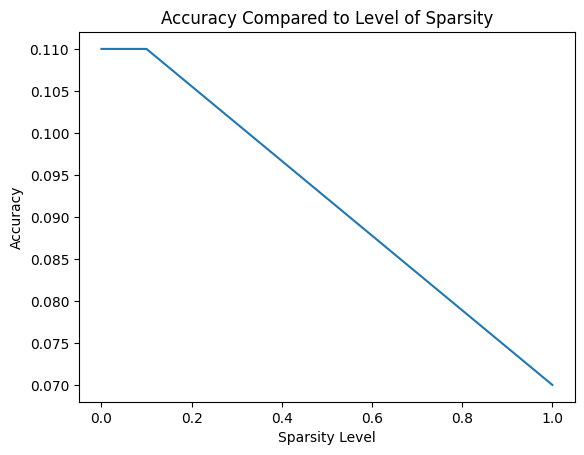

In [105]:
import sys

# Evaluate zero-shot classification performance
print(f"Dense Accuracy: {dense_acc}")
print(f"Sparse Accuracy: {sparse_acc}")

# Plot relationship between sparsity and classification accuracy
sparsity_levels = [0.0001, 0.001, 0.01, 0.1, 1]
accuracies = []
for sparsity in sparsity_levels:
    sparse_embeddings_sparsity = z_hat_img*(z_hat_img > sparsity)
    pred_sparse1=zero_shot(sparse_embeddings_sparsity,z_txt)
    accuracy=accuracy_zero_shot(pred_sparse1)
    accuracies.append(accuracy)
plt.plot(sparsity_levels, accuracies)
plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy")
plt.title("Accuracy Compared to Level of Sparsity")

# Compare memory footprint of dense and sparse embeddings
dense_memory_footprint = sys.getsizeof(z_img)
sparse_memory_footprint = sys.getsizeof(z_hat_img.detach())
print(f"Dense memory footprint: {dense_memory_footprint} bytes")
print(f"Sparse memory footprint: {sparse_memory_footprint} bytes")

# Analyze sparse embeddings to identify most active concepts
concept_activations = z_hat_img.sum(dim=0)
top_concepts = concept_activations.argsort()[:10]
print(f"Top concepts: {top_concepts}")